In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load training data and plot it

Note how the data is loaded with `train = True`. You can load the test data in a similar fashion, just set `train = False`. Feel free to reuse my plot function!

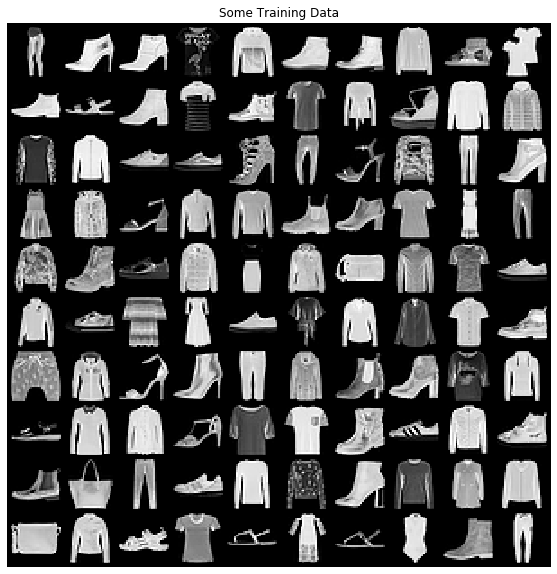

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 100
train_data = FashionMNIST("./data", train = True, download = True,
                          transform=transforms.ToTensor())
data_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

width = 28
height = 28
input_size = width * height

def plot_images(batch, rows, cols, title = ""):
    plt.figure(figsize = (rows, cols))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(
        vutils.make_grid(batch[:(rows * cols)], nrow = rows, normalize = True).cpu(),
        (1, 2, 0)))

first_batch = next(iter(data_loader))
plot_images(first_batch[0], 10, 10, "Some Training Data")

## Define Models

In [ ]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(FullyConnectedAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, out_size),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(out_size, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, input_size)
        z = self.encoder(x)
        y = self.decoder(z)
        y = y.view(-1, 1, width, height)
        return y

class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, out_size):
        super(ConvolutionalAutoencoder, self).__init__()
        self.econv1 = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
        self.ebatch1 = nn.BatchNorm2d(32)
        self.econv2 = nn.Conv2d(32, 8, kernel_size = 5, bias = False)
        self.ebatch2 = nn.BatchNorm2d(8)
        self.econv3 = nn.Conv2d(8, out_size, kernel_size = 20, bias = True)

        self.dconv1 = nn.ConvTranspose2d(out_size, 8, kernel_size = 20, bias = True)
        self.dbatch1 = nn.BatchNorm2d(8)
        self.dconv2 = nn.ConvTranspose2d(8, 32, kernel_size = 5, bias = False)
        self.dbatch2 = nn.BatchNorm2d(32)
        self.dconv3 = nn.ConvTranspose2d(32, 1, kernel_size = 5, bias = False)

    def encoder(self, x):
        y1 = F.elu(self.ebatch1(self.econv1(x)))
        y2 = F.elu(self.ebatch2(self.econv2(y1)))
        z = F.elu(self.econv3(y2))
        return z

    def decoder(self, z):
        y1 = F.elu(self.dbatch1(self.dconv1(z)))
        y2 = F.elu(self.dbatch2(self.dconv2(y1)))
        x = torch.sigmoid(self.dconv3(y2))
        return x
     
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

## Train Models

The rest of the code below trains the models. Do not include this code in your solution and don't run it! (it takes forever without a GPU) Instead load the pre-trained models from the course website. This is included in case you want to see how I trained the models, and if you want to play with them beyond what is required.

In [ ]:
def train(autoencoder, num_epochs = 20, learn_rate = 0.5):
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr = learn_rate)
    mse_loss = nn.MSELoss()

    for epoch in range(num_epochs):
        tot_loss = 0
        for i, (x, label) in enumerate(data_loader):
            x = x.to(device)
            y = autoencoder(x)

            loss = mse_loss(x, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tot_loss = tot_loss + loss.data.cpu().numpy()

        print(epoch, ": Loss =", tot_loss)
        
    return autoencoder

In [ ]:
fcAE16 = FullyConnectedAutoencoder(16)
fcAE16 = train(fcAE16.to(device))
torch.save(fcAE16.state_dict(), "fcAE16.pth")

In [ ]:
fcAE32 = FullyConnectedAutoencoder(32)
fcAE32 = train(fcAE32.to(device))
torch.save(fcAE32.state_dict(), "fcAE32.pth")

In [ ]:
fcAE128 = FullyConnectedAutoencoder(128)
fcAE128 = train(fcAE128.to(device))
torch.save(fcAE128.state_dict(), "fcAE128.pth")

In [ ]:
convAE16 = ConvolutionalAutoencoder(16)
convAE16 = train(convAE16.to(device))
torch.save(convAE16.state_dict(), "convAE16.pth")

In [ ]:
convAE32 = ConvolutionalAutoencoder(32)
convAE32 = train(convAE32.to(device))
torch.save(convAE32.state_dict(), "convAE32.pth")

In [ ]:
convAE128 = ConvolutionalAutoencoder(128)
convAE128 = train(convAE128.to(device))
torch.save(convAE128.state_dict(), "convAE128.pth")